<a href="https://colab.research.google.com/github/gitarthasarma/Computer-Vision-Projects/blob/main/2_Image_Classification_using_ResNets%2C_Regularization_and_Data_Augmentation_on_CIFAR10_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import all libraries

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as tt
import matplotlib
import matplotlib.pyplot as plt

from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = "#ffffff"

#Preparing the dataset and dataloaders

In [30]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [31]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path = "./data")

data_dir = './data/cifar10'

In [32]:
#data transformation(normalization and augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_transforms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode="reflect"),
                               tt.RandomHorizontalFlip(),
                               tt.ToTensor(),
                               tt.Normalize(*stats, inplace=True)])

valid_transforms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [33]:
#datasets
train_ds = ImageFolder(data_dir + '/train', train_transforms)
valid_ds = ImageFolder(data_dir + '/test', valid_transforms)

batch_size = 400

#dataloader
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#Helper Functions and GPU CUDA code

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


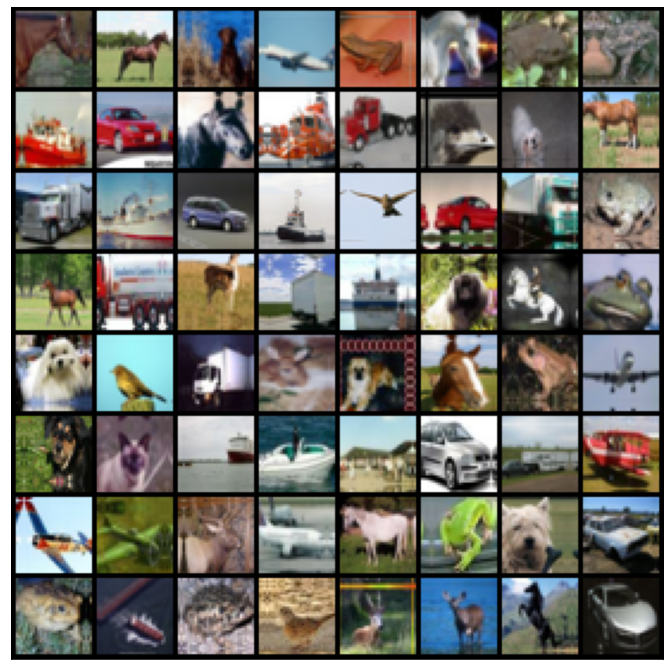

In [34]:
# to display images, we need to denormalize the images
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)
  return images*stds + means

#display input image
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([])
    ax.set_yticks([])
    denorm_images = denormalize(images, *stats)
    ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
    break
  
show_batch(train_dl)

In [35]:
#code for running on gpu

def get_default_device():
  """ Pick up GPU if its available else use CPU """
  if torch.cuda.is_available():
    return torch.device("cuda")
  return torch.device("cpu")

def to_device(data, device):
  """ Move tensors to device """
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)


# wrapper dataloader

class DeviceDataLoader():
  """ Wrap a dataloader to move data to a device """
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    """ Return the dataloader generator object, so no need to implement __next__ """
    for b in self.dl:
      yield to_device(b, self.device)
    
  def __len__(self):
    """ Number of batches """
    return len(self.dl)

  

In [36]:
device = get_default_device()
print(device)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

cuda


#Network

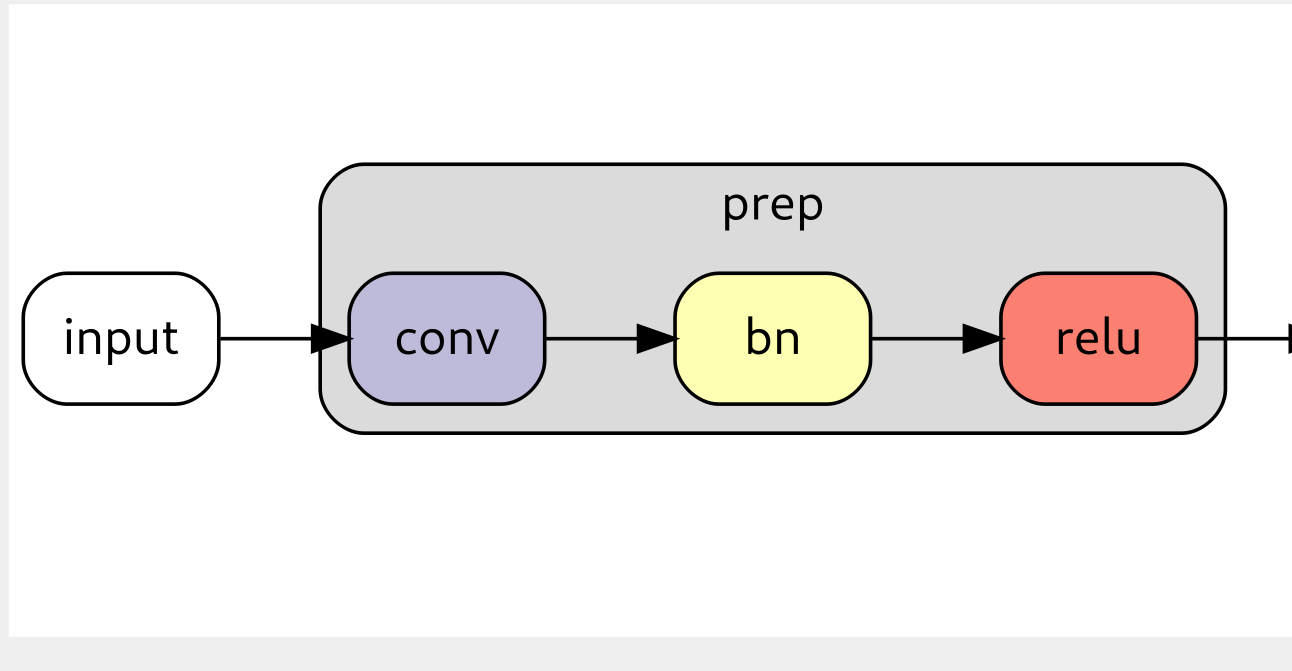

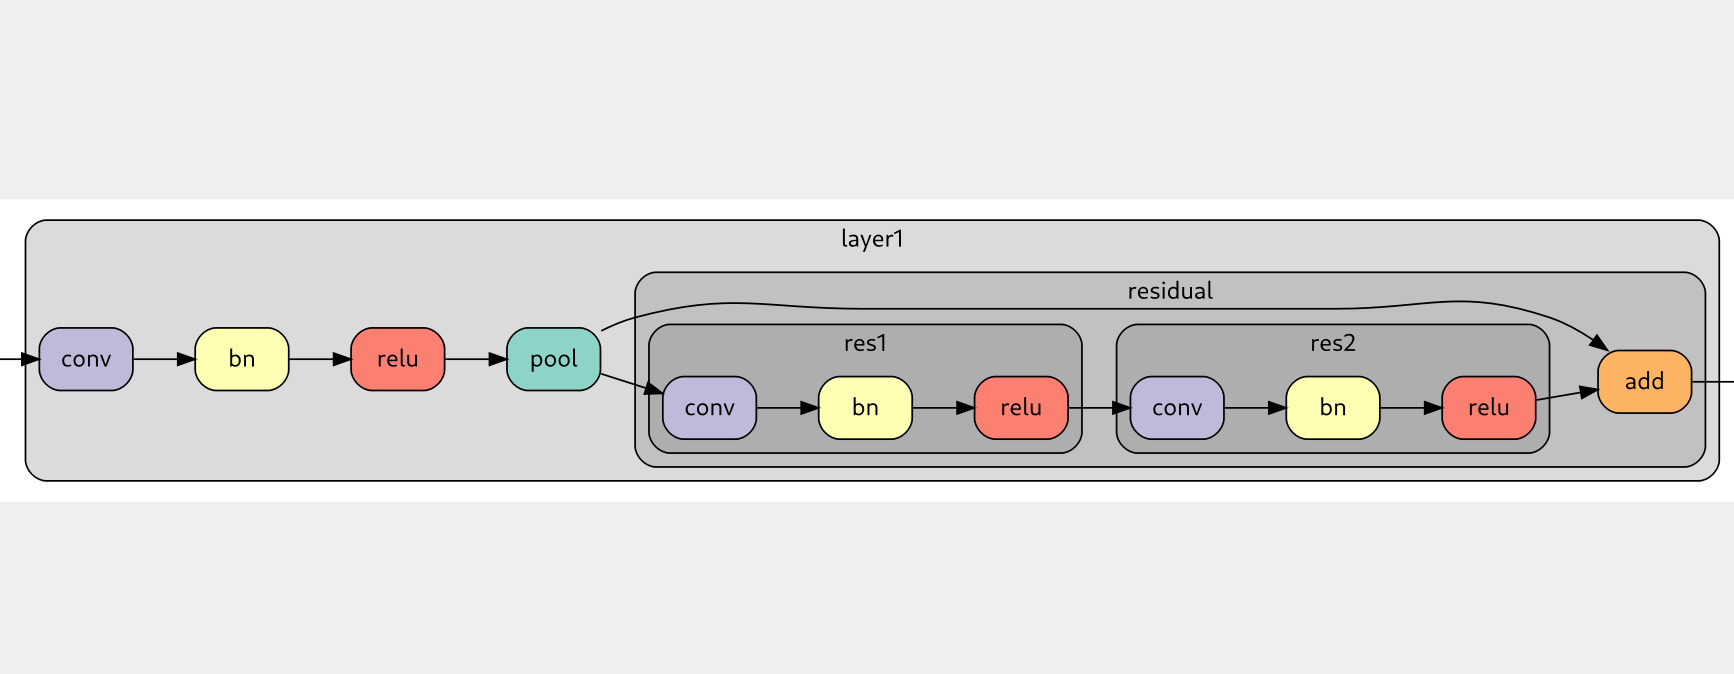

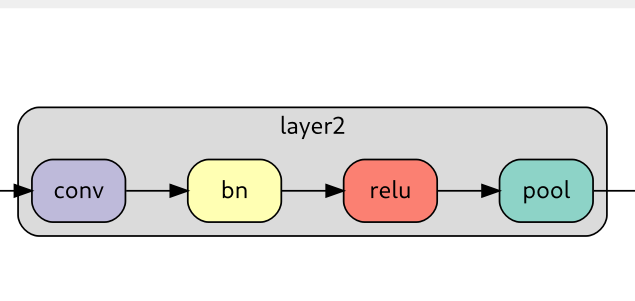

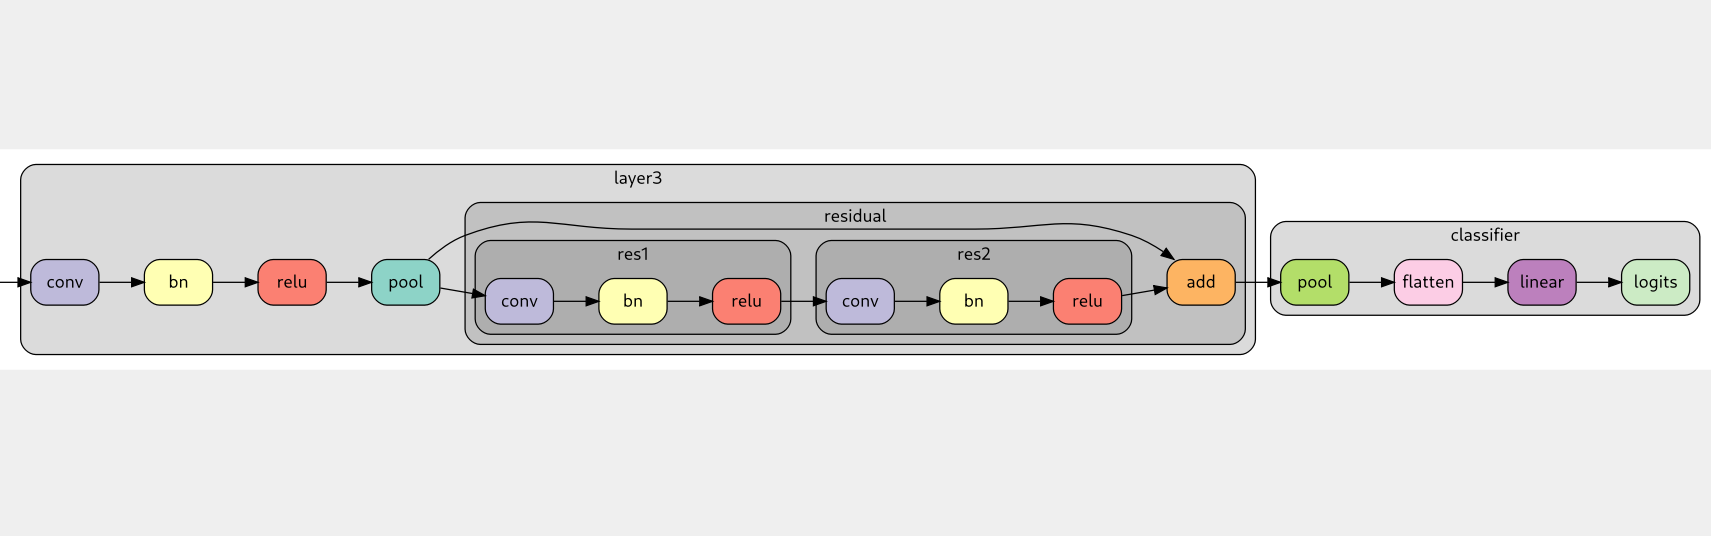

[full network](https://raw.githubusercontent.com/lambdal/cifar10-fast/master/net.svg)

In [37]:
# accuracy helper function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the network
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [38]:
#Return a convolution block

def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool:
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)


class Resnet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    #prep
    self.conv1 = conv_block(in_channels, 64)

    #layer1
    self.conv2 = conv_block(64, 128, pool=True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

    #layer2
    self.conv3 = conv_block(128, 256, pool=True)
    
    #layer3
    self.conv4 = conv_block(256,512, pool=True)
    self.res2 = nn.Sequential(conv_block(512,512,), conv_block(512, 512))

    #layer4
    self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, num_classes))
  

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)

    return out



In [39]:
model = to_device(Resnet9(3,10), device)
model

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

#Training the model


In [40]:
@torch.no_grad()
def evaluate(model, valid_dl):
  model.eval()
  outputs = [model.validation_step(batch) for batch in valid_dl]
  return model.validation_epoch_end(outputs)


def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']


def fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, weight_decay=0,
                  grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []

  # custom optimizer with weight decay
  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

  # set up one cycle learning rate scheduler
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,
                                                   epochs=epochs,
                                                   steps_per_epoch=len(train_dl))
  
  for epoch in range(epochs):
    # training
    model.train()
    train_losses = []
    lrs = []

    for batch in train_dl:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      #gradient clipping
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
      
      optimizer.step()
      optimizer.zero_grad()

      #record and update learning rate
      lrs.append(get_lr(optimizer))
      scheduler.step()
    
    #validation
    result = evaluate(model, valid_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
  
  return history

In [41]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [42]:
%%time
history = []
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00393, train_loss: 1.4886, val_loss: 1.2936, val_acc: 0.5755
Epoch [1], last_lr: 0.00935, train_loss: 1.0963, val_loss: 2.5798, val_acc: 0.3979
Epoch [2], last_lr: 0.00972, train_loss: 0.8426, val_loss: 0.7762, val_acc: 0.7303
Epoch [3], last_lr: 0.00812, train_loss: 0.6328, val_loss: 0.7229, val_acc: 0.7565
Epoch [4], last_lr: 0.00556, train_loss: 0.5102, val_loss: 0.5640, val_acc: 0.8133
Epoch [5], last_lr: 0.00283, train_loss: 0.4004, val_loss: 0.3955, val_acc: 0.8636
Epoch [6], last_lr: 0.00077, train_loss: 0.2909, val_loss: 0.3138, val_acc: 0.8920
Epoch [7], last_lr: 0.00000, train_loss: 0.2222, val_loss: 0.2838, val_acc: 0.9020
CPU times: user 42.3 s, sys: 15.2 s, total: 57.5 s
Wall time: 4min 26s


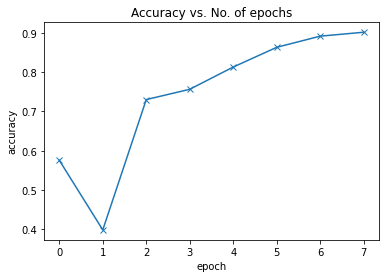

In [43]:
#plotting accuracies
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

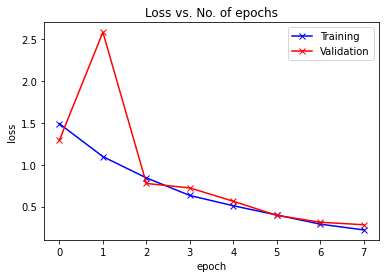

In [44]:
#plotting losses
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

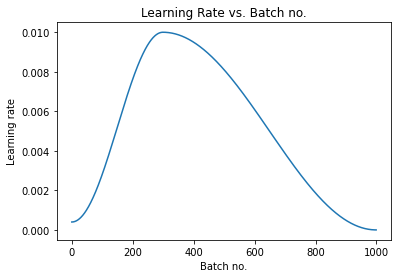

In [45]:
#plotting learning rates across epochs
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

#Testing the model

In [46]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: airplane , Predicted: airplane


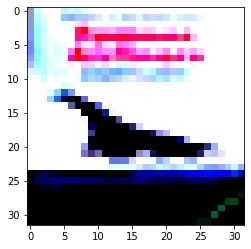

In [47]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: airplane , Predicted: truck


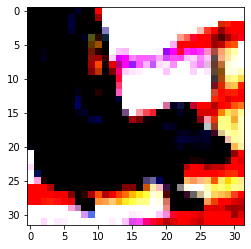

In [48]:
img, label = valid_ds[121]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))